<a href="https://colab.research.google.com/github/LuisLgl/SI-Naive-VS-KNN/blob/main/TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importações

In [1]:
pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, cohen_kappa_score
)

## Carregar Dataset

In [3]:
data = fetch_ucirepo(id=529)

X = data.data.features.copy()
y = data.data.targets.copy().squeeze()

print("Dataset carregado:", X.shape, "\n")


Dataset carregado: (520, 16) 



## Codificar Alvo

In [4]:
# Codificar o alvo para valores inteiros (obrigatório para one-hot)
le_y = LabelEncoder()
y = le_y.fit_transform(y)


## Análise Exploratória

In [5]:
# Proporções da variável alvo
unique, counts = np.unique(y, return_counts=True)
proporcoes = counts / counts.sum()

print("=== Distribuição da Variável Alvo ===")
for u, p in zip(unique, proporcoes):
    print(f"{u}: {p*100:.2f}%")

# Identificação automática de tipos
colunas_continuas = X.select_dtypes(include=['float64', 'int64']).columns
colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns

print("\nColunas contínuas:", list(colunas_continuas))
print("Colunas categóricas:", list(colunas_categoricas))

# Valores faltantes
faltantes = X.isna().sum()
print("\nValores faltantes encontrados (se houver):")
print(faltantes[faltantes > 0] if any(faltantes > 0) else "Nenhum faltante")


=== Distribuição da Variável Alvo ===
0: 38.46%
1: 61.54%

Colunas contínuas: ['age']
Colunas categóricas: ['gender', 'polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity']

Valores faltantes encontrados (se houver):
Nenhum faltante


## Tratamento inicial

In [6]:
X[colunas_continuas] = X[colunas_continuas].fillna(0)
X[colunas_categoricas] = X[colunas_categoricas].fillna("missing")


## Pré-Processamento

In [7]:
# --------- KNN ---------
def preprocess_knn_train(X_train, col_cont, col_cat):
    X2 = X_train.copy()
    enc = {}

    for col in col_cat:
        le = LabelEncoder()
        X2[col] = le.fit_transform(X2[col])
        enc[col] = le

    scaler = StandardScaler()
    X2[col_cont] = scaler.fit_transform(X2[col_cont])

    return X2, enc, scaler

def preprocess_knn_apply(X, col_cont, col_cat, enc, scaler):
    X2 = X.copy()
    for col in col_cat:
        X2[col] = enc[col].transform(X2[col])
    X2[col_cont] = scaler.transform(X2[col_cont])
    return X2

# --------- Naive Bayes ---------
def preprocess_nb_train(X_train, col_cont, col_cat, n_bins=10):
    X2 = X_train.copy()
    enc = {}

    for col in col_cat:
        le = LabelEncoder()
        X2[col] = le.fit_transform(X2[col])
        enc[col] = le

    kb = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    X2[col_cont] = kb.fit_transform(X2[col_cont])

    return X2, enc, kb

def preprocess_nb_apply(X, col_cont, col_cat, enc, kb):
    X2 = X.copy()
    for col in col_cat:
        X2[col] = enc[col].transform(X2[col])
    X2[col_cont] = kb.transform(X2[col_cont])
    return X2

def one_hot_targets(y):
    return np.eye(len(np.unique(y)))[y]


## Configuração do Kfold

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_knn = {'acc':[], 'prec':[], 'rec':[], 'f1':[], 'auc':[], 'kappa':[]}
metrics_nb  = {'acc':[], 'prec':[], 'rec':[], 'f1':[], 'auc':[], 'kappa':[]}
tempos_knn, tempos_nb = [], []


## Loop Kfold

In [9]:
for train_idx, val_idx in skf.split(X, y):

    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y[train_idx], y[val_idx]

    # Pré-processamento KNN
    X_train_knn, enc_knn, scale_knn = preprocess_knn_train(X_train, colunas_continuas, colunas_categoricas)
    X_val_knn = preprocess_knn_apply(X_val, colunas_continuas, colunas_categoricas, enc_knn, scale_knn)

    # Pré-processamento NB
    X_train_nb, enc_nb, kb_nb = preprocess_nb_train(X_train, colunas_continuas, colunas_categoricas)
    X_val_nb = preprocess_nb_apply(X_val, colunas_continuas, colunas_categoricas, enc_nb, kb_nb)

    y_val_bin = one_hot_targets(y_val)

    # ----- KNN -----
    ini = time.time()
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_knn, y_train)
    y_pred = knn.predict(X_val_knn)
    y_prob = knn.predict_proba(X_val_knn)
    fim = time.time()

    tempos_knn.append(fim - ini)
    metrics_knn['acc'].append(accuracy_score(y_val, y_pred))
    metrics_knn['prec'].append(precision_score(y_val, y_pred, average='weighted'))
    metrics_knn['rec'].append(recall_score(y_val, y_pred, average='weighted'))
    metrics_knn['f1'].append(f1_score(y_val, y_pred, average='weighted'))
    metrics_knn['auc'].append(roc_auc_score(y_val_bin, y_prob, multi_class='ovr', average='weighted'))
    metrics_knn['kappa'].append(cohen_kappa_score(y_val, y_pred))

    # ----- Naive Bayes -----
    ini = time.time()
    nb = CategoricalNB()
    nb.fit(X_train_nb, y_train)
    y_pred = nb.predict(X_val_nb)
    y_prob = nb.predict_proba(X_val_nb)
    fim = time.time()

    tempos_nb.append(fim - ini)
    metrics_nb['acc'].append(accuracy_score(y_val, y_pred))
    metrics_nb['prec'].append(precision_score(y_val, y_pred, average='weighted'))
    metrics_nb['rec'].append(recall_score(y_val, y_pred, average='weighted'))
    metrics_nb['f1'].append(f1_score(y_val, y_pred, average='weighted'))
    metrics_nb['auc'].append(roc_auc_score(y_val_bin, y_prob, multi_class='ovr', average='weighted'))
    metrics_nb['kappa'].append(cohen_kappa_score(y_val, y_pred))


## Impressão das Métricas

In [10]:
def print_metrics(name, metrics):
    print(f"\n=== {name} — K-FOLD (5) ===")
    for m in metrics:
        print(f"{m.upper()}: {np.mean(metrics[m]):.4f} ± {np.std(metrics[m]):.4f}")

print_metrics("KNN", metrics_knn)
print_metrics("Naive Bayes", metrics_nb)



=== KNN — K-FOLD (5) ===
ACC: 0.9135 ± 0.0192
PREC: 0.9215 ± 0.0139
REC: 0.9135 ± 0.0192
F1: 0.9143 ± 0.0188
AUC: 0.9785 ± 0.0083
KAPPA: 0.8221 ± 0.0375

=== Naive Bayes — K-FOLD (5) ===
ACC: 0.8846 ± 0.0219
PREC: 0.8957 ± 0.0134
REC: 0.8846 ± 0.0219
F1: 0.8857 ± 0.0213
AUC: 0.9501 ± 0.0163
KAPPA: 0.7636 ± 0.0408


## Tabela das Métricas

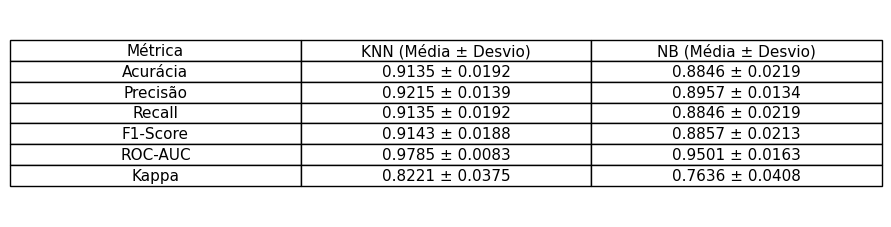

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === SUA TABELA ORIGINAL ===
metricas = ["Acurácia", "Precisão", "Recall", "F1-Score", "ROC-AUC", "Kappa"]

knn_media = [np.mean(metrics_knn[m]) for m in ['acc','prec','rec','f1','auc','kappa']]
knn_desvio = [np.std(metrics_knn[m]) for m in ['acc','prec','rec','f1','auc','kappa']]

nb_media = [np.mean(metrics_nb[m]) for m in ['acc','prec','rec','f1','auc','kappa']]
nb_desvio = [np.std(metrics_nb[m]) for m in ['acc','prec','rec','f1','auc','kappa']]

# === COMBINAR MÉDIA ± DESVIO EM UMA ÚNICA COLUNA ===
knn_comb = [f"{m:.4f} ± {s:.4f}" for m, s in zip(knn_media, knn_desvio)]
nb_comb = [f"{m:.4f} ± {s:.4f}" for m, s in zip(nb_media, nb_desvio)]

df = pd.DataFrame({
    "Métrica": metricas,
    "KNN (Média ± Desvio)": knn_comb,
    "NB (Média ± Desvio)": nb_comb
})

# === GERAR A IMAGEM ===
fig, ax = plt.subplots(figsize=(9, 2.7))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.25, 1.25)
plt.show()


## Gráficos das Métricas

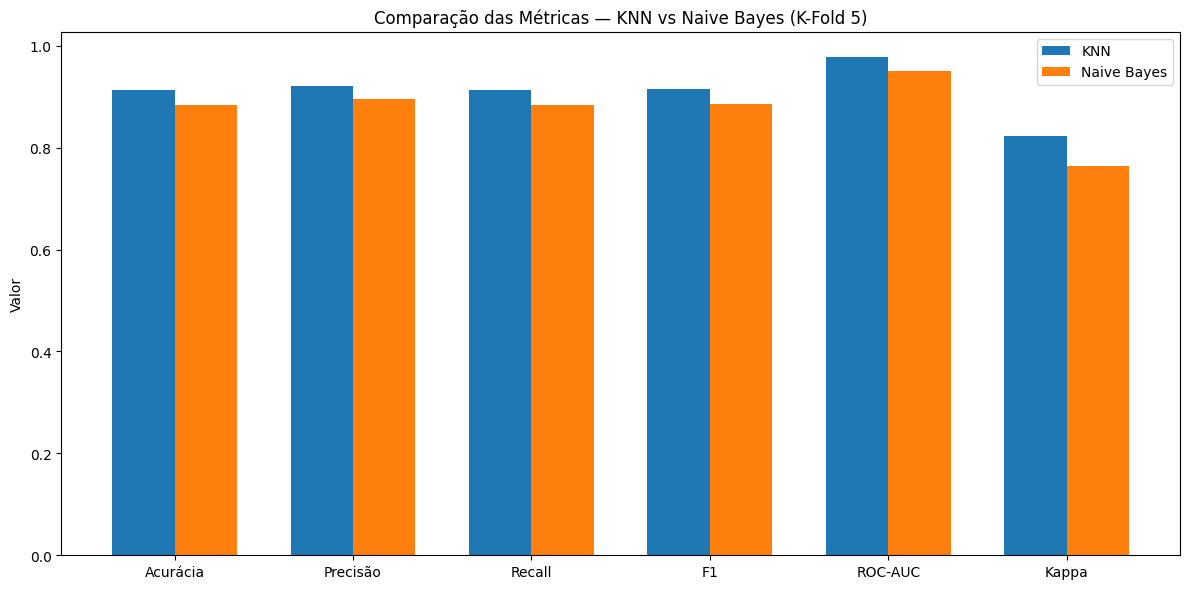

In [12]:
metricas = ["Acurácia", "Precisão", "Recall", "F1", "ROC-AUC", "Kappa"]
knn_vals = [np.mean(metrics_knn[m]) for m in ['acc','prec','rec','f1','auc','kappa']]
nb_vals  = [np.mean(metrics_nb[m])  for m in ['acc','prec','rec','f1','auc','kappa']]

x = np.arange(len(metricas))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, knn_vals, width, label="KNN")
plt.bar(x + width/2, nb_vals, width, label="Naive Bayes")

plt.xticks(x, metricas)
plt.ylabel("Valor")
plt.title("Comparação das Métricas — KNN vs Naive Bayes (K-Fold 5)")
plt.legend()
plt.tight_layout()
plt.show()


## Gráfico dos Tempos

Tempo médio KNN: 0.0127 segundos
Tempo médio Naive Bayes: 0.0086 segundos


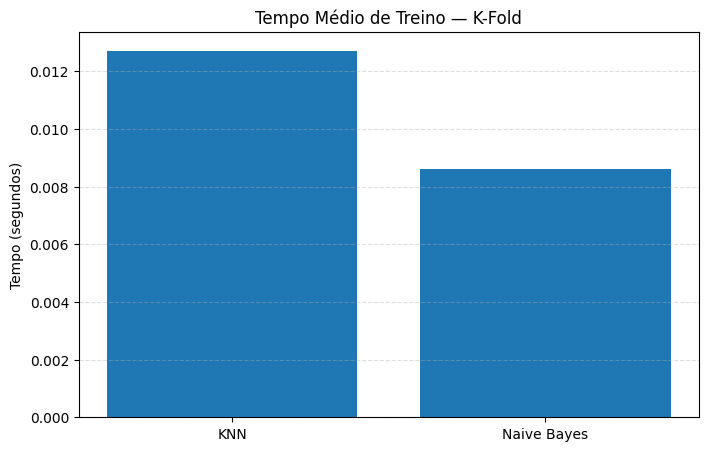

In [13]:
mean_knn = np.mean(tempos_knn)
mean_nb  = np.mean(tempos_nb)

print(f"Tempo médio KNN: {mean_knn:.4f} segundos")
print(f"Tempo médio Naive Bayes: {mean_nb:.4f} segundos")


modelos = ["KNN", "Naive Bayes"]
tempos = [mean_knn, mean_nb]

plt.figure(figsize=(8,5))
plt.bar(modelos, tempos)
plt.ylabel("Tempo (segundos)")
plt.title("Tempo Médio de Treino — K-Fold")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()
